# TODO List
- Graph based causal modellerin implementasyonu
- NLP based causal modellerin implementasyonu
- Text özelliklerinin embeddingini oluşturdukdan sonra, tree based model eğitip shap vs. ile model interpret raporları


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from causalgraphicalmodels import CausalGraphicalModel
from dowhy import CausalModel
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

%load_ext jupyter_black
pd.options.display.max_columns = 300

import warnings

warnings.filterwarnings("ignore")

In [2]:
alaka = pd.read_csv("alaka_skorları.csv")
ilan = pd.read_csv("ilan_bilgileri.csv")

In [3]:
alaka["item_id"] = alaka["item_id"].astype(str)
ilan["id"] = ilan["id"].astype(str)
df = pd.merge(ilan, alaka, left_on="id", right_on="item_id")
df = df.sample(n=20000)  # modeller uzun sürmesin diye sample aldım

In [4]:
cats = df.select_dtypes("object").columns.tolist()
nums = df.select_dtypes(["int", "float"]).columns.tolist()

df[cats] = df[cats].fillna("unk")
df[nums] = df[nums].fillna(0)

# causal tabular model

In [5]:
def run_causal(df, treatment, outcome):
    """
    Runs a causal analysis on the provided dataframe.

    Parameters:
    df (pd.DataFrame): The input dataframe containing the data for analysis.
    treatment (str): The treatment variable for the causal analysis.
    outcome (str): The outcome variable for the causal analysis.

    Returns:
    None
    """

    causal_graph = CausalGraphicalModel(
        nodes=[
            "kategori_1",
            "kategori_2",
            "kategori_3",
            "mahalle",
            "ilce",
            "il",
            "ilan_baslik",
            "ilan_fiyat",
            "ilan_sahip_adi",
            "site_icinde_mi",
            "m2_gross",
            "m2_net",
            "bina_kat_sayisi",
            "cephe",
            "sosyal_imkanlar",
            "bina_ozellikleri",
            "ulasim",
            "oda_sayisi",
            "ilan_kat_sayisi",
            "bina_yasi",
            "ilab_query",
            outcome,
        ],
        edges=[
            ("ilab_query", outcome),
            ("kategori_1", outcome),
            ("kategori_2", outcome),
            ("kategori_3", outcome),
            ("mahalle", outcome),
            ("ilce", outcome),
            ("il", outcome),
            ("ilan_baslik", outcome),
            ("ilan_fiyat", outcome),
            ("ilan_sahip_adi", outcome),
            ("site_icinde_mi", outcome),
            ("m2_gross", outcome),
            ("m2_net", outcome),
            ("bina_kat_sayisi", outcome),
            ("cephe", outcome),
            ("sosyal_imkanlar", outcome),
            ("bina_ozellikleri", outcome),
            ("ulasim", outcome),
            ("oda_sayisi", outcome),
            ("ilan_kat_sayisi", outcome),
            ("bina_yasi", outcome),
        ],
    )

    display(causal_graph.draw())

    y = df[outcome]
    X = df.drop(
        columns=[
            "query_id",
            "item_id",
            "attr",
            "sat_click",
            "sat_pur",
            "pur",
            "cont",
            "relevance",
            "date",
        ]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    encoder = TargetEncoder()
    X_train_encoded = encoder.fit_transform(X_train, y_train)
    X_test_encoded = encoder.transform(X_test)

    df_encoded = pd.concat([X_train_encoded, y_train], axis=1)

    common_causes = [
        col for col in df_encoded.columns if col not in [outcome, treatment]
    ]

    model = CausalModel(
        data=df_encoded,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes,
    )

    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print(identified_estimand)

    linear_estimate = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression"
    )
    print(linear_estimate)

    refute_placebo = model.refute_estimate(
        identified_estimand, linear_estimate, method_name="placebo_treatment_refuter"
    )
    print(refute_placebo)

    refute_subset = model.refute_estimate(
        identified_estimand, linear_estimate, method_name="data_subset_refuter"
    )
    print(refute_subset)

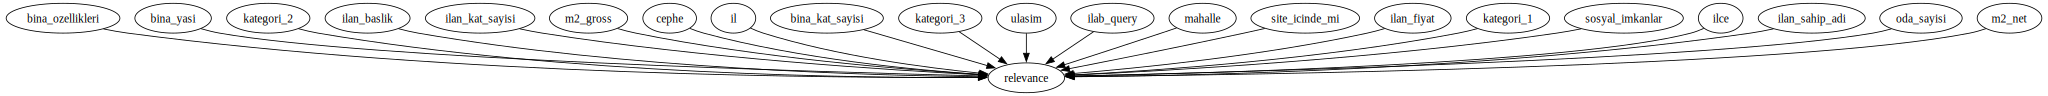

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[relevance|bina_ozellikleri,bina_yasi,kategori_2,updated_at,ila
d[ilab_query]                                                                 

                                                                              
n_baslik,ilan_kat_sayisi,m2_gross,cephe,category_id,row_num,il,bina_kat_sayisi
                                                                              

                                                                              
,kategori_3,ulasim,created_at,mahalle,id,site_icinde_mi,ilan_fiyat,kategori_1,
                                                                              

                                                                
sosyal_imkanlar,ilce,ilan_sahip_adi,etl_date,oda_sayisi,m2_net])
                                               

In [6]:
run_causal(df, "ilab_query", "relevance")

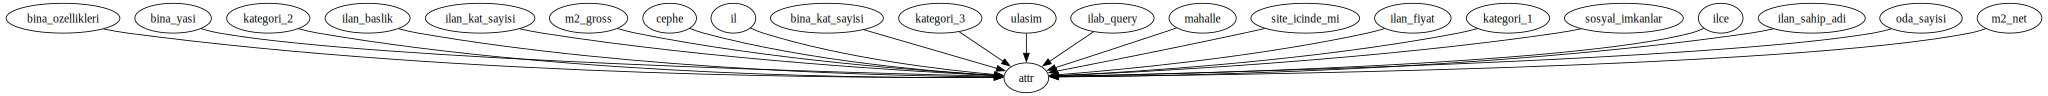

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(E[attr|bina_ozellikleri,bina_yasi,kategori_2,updated_at,ilan_bas
d[ilab_query]                                                                 

                                                                              
lik,ilan_kat_sayisi,m2_gross,cephe,category_id,row_num,il,bina_kat_sayisi,kate
                                                                              

                                                                              
gori_3,ulasim,created_at,mahalle,id,site_icinde_mi,ilan_fiyat,kategori_1,sosya
                                                                              

                                                           
l_imkanlar,ilce,ilan_sahip_adi,etl_date,oda_sayisi,m2_net])
                                                         

In [7]:
run_causal(df, "ilab_query", "attr")

# graph based causality - feature importance

In [8]:
class Node:
    """
    A base class representing a node in the graph.

    Attributes:
    node_id (str): The unique identifier for the node.
    """

    def __init__(self, node_id):
        self.node_id = node_id


class AdNode(Node):
    """
    A class representing an advertisement node in the graph.

    Attributes:
    node_id (str): The unique identifier for the ad node.
    kategori_1 (str): The first category of the ad.
    kategori_2 (str): The second category of the ad.
    kategori_3 (str): The third category of the ad.
    mahalle (str): The neighborhood of the ad.
    ilce (str): The district of the ad.
    il (str): The city of the ad.
    ilan_baslik (str): The title of the ad.
    ilan_fiyat (float): The price of the ad.
    ilan_sahip_adi (str): The name of the ad owner.
    site_icinde_mi (bool): Indicates if the ad is within a site.
    m2_gross (float): The gross square meter area of the property.
    m2_net (float): The net square meter area of the property.
    bina_kat_sayisi (int): The number of floors in the building.
    cephe (str): The facade direction of the property.
    sosyal_imkanlar (str): The social facilities available.
    bina_ozellikleri (str): The characteristics of the building.
    ulasim (str): The transportation options available.
    oda_sayisi (int): The number of rooms in the property.
    ilan_kat_sayisi (int): The number of floors listed in the ad.
    bina_yasi (int): The age of the building.
    """

    def __init__(
        self,
        node_id,
        kategori_1,
        kategori_2,
        kategori_3,
        mahalle,
        ilce,
        il,
        ilan_baslik,
        ilan_fiyat,
        ilan_sahip_adi,
        site_icinde_mi,
        m2_gross,
        m2_net,
        bina_kat_sayisi,
        cephe,
        sosyal_imkanlar,
        bina_ozellikleri,
        ulasim,
        oda_sayisi,
        ilan_kat_sayisi,
        bina_yasi,
    ):
        super().__init__(node_id)
        self.kategori_1 = kategori_1
        self.kategori_2 = kategori_2
        self.kategori_3 = kategori_3
        self.mahalle = mahalle
        self.ilce = ilce
        self.il = il
        self.ilan_baslik = ilan_baslik
        self.ilan_fiyat = ilan_fiyat
        self.ilan_sahip_adi = ilan_sahip_adi
        self.site_icinde_mi = site_icinde_mi
        self.m2_gross = m2_gross
        self.m2_net = m2_net
        self.bina_kat_sayisi = bina_kat_sayisi
        self.cephe = cephe
        self.sosyal_imkanlar = sosyal_imkanlar
        self.bina_ozellikleri = bina_ozellikleri
        self.ulasim = ulasim
        self.oda_sayisi = oda_sayisi
        self.ilan_kat_sayisi = ilan_kat_sayisi
        self.bina_yasi = bina_yasi


class QueryNode(Node):
    """
    A class representing a query node in the graph.

    Attributes:
    node_id (str): The unique identifier for the query node.
    ilab_query (str): The query string.
    """

    def __init__(self, node_id, ilab_query):
        super().__init__(node_id)
        self.ilab_query = ilab_query


graph = nx.DiGraph()

In [9]:
# Add ad nodes
ad_features = [
    "kategori_1",
    "kategori_2",
    "kategori_3",
    "mahalle",
    "ilce",
    "il",
    "ilan_baslik",
    "ilan_fiyat",
    "ilan_sahip_adi",
    "site_icinde_mi",
    "m2_gross",
    "m2_net",
    "bina_kat_sayisi",
    "cephe",
    "sosyal_imkanlar",
    "bina_ozellikleri",
    "ulasim",
    "oda_sayisi",
    "ilan_kat_sayisi",
    "bina_yasi",
]

for _, row in df.iterrows():
    ad_node = AdNode(
        node_id=row["id"],
        kategori_1=row["kategori_1"],
        kategori_2=row["kategori_2"],
        kategori_3=row["kategori_3"],
        mahalle=row["mahalle"],
        ilce=row["ilce"],
        il=row["il"],
        ilan_baslik=row["ilan_baslik"],
        ilan_fiyat=row["ilan_fiyat"],
        ilan_sahip_adi=row["ilan_sahip_adi"],
        site_icinde_mi=row["site_icinde_mi"],
        m2_gross=row["m2_gross"],
        m2_net=row["m2_net"],
        bina_kat_sayisi=row["bina_kat_sayisi"],
        cephe=row["cephe"],
        sosyal_imkanlar=row["sosyal_imkanlar"],
        bina_ozellikleri=row["bina_ozellikleri"],
        ulasim=row["ulasim"],
        oda_sayisi=row["oda_sayisi"],
        ilan_kat_sayisi=row["ilan_kat_sayisi"],
        bina_yasi=row["bina_yasi"],
    )
    graph.add_node(ad_node.node_id, **vars(ad_node))

# Add query nodes
for _, row in df.iterrows():
    query_node = QueryNode(node_id=row["query_id"], ilab_query=row["ilab_query"])
    graph.add_node(query_node.node_id, **vars(query_node))

# Add edges
edge_attrs = ["attr", "sat_click", "sat_pur", "pur", "cont", "relevance"]
for _, row in df.iterrows():
    edge_attr = {attr: row[attr] for attr in edge_attrs}
    graph.add_edge(row["id"], row["query_id"], **edge_attr)

In [10]:
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 27656
Number of edges: 20000


In [11]:
ad_node_id = df["id"].iloc[0]
query_node_id = df["query_id"].iloc[0]

In [12]:
# Print all features of the specific ad node from the graph
ad_features = [
    "kategori_1",
    "kategori_2",
    "kategori_3",
    "mahalle",
    "ilce",
    "il",
    "ilan_baslik",
    "ilan_fiyat",
    "ilan_sahip_adi",
    "site_icinde_mi",
    "m2_gross",
    "m2_net",
    "bina_kat_sayisi",
    "cephe",
    "sosyal_imkanlar",
    "bina_ozellikleri",
    "ulasim",
    "oda_sayisi",
    "ilan_kat_sayisi",
    "bina_yasi",
]


ad_node = graph.nodes[ad_node_id]
print(f"Ad Node ID: {ad_node_id}")
for feature in ad_features:
    print(f"{feature}: {ad_node[feature]}")

# Display the ad node features from the datafram
ad_node_details = df.query(f"id=='{ad_node_id}'")[["id"] + ad_features].T
ad_node_details

Ad Node ID: 13109529
kategori_1: rent
kategori_2: konut
kategori_3: daire
mahalle: Boyalık Mahallesi
ilce: Çeşme
il: İzmir
ilan_baslik:  ALAÇATI GAYRİMENKULDEN SEZONLUK KİRALIK SIFIR DAİRELER
ilan_fiyat: 200000.0
ilan_sahip_adi: Alaçatı Gayrimenkul
site_icinde_mi: False
m2_gross: 75.0
m2_net: 60.0
bina_kat_sayisi: 4.0
cephe: Güney Cepheli&Kuzey Cepheli
sosyal_imkanlar: Engelliye Uygun&Açık Otopark&Çocuk Parkı&Yürüyüş Parkuru
bina_ozellikleri: Hırsız Alarmı&Yangın Merdiveni&Asansör&Ses Yalıtımı&Yangın Alarmı&Güvenlik&Hidrofor&Isıcam&Alüminyum Doğrama&Isı Yalıtımı&Apartman Görevlisi
ulasim: Anayol&Denize Yakın&Minibüs&Otoban
oda_sayisi: 1+1
ilan_kat_sayisi: 4
bina_yasi: 0 (Yeni)


,132894
id,13109529
kategori_1,rent
kategori_2,konut
kategori_3,daire
mahalle,Boyalık Mahallesi
ilce,Çeşme
il,İzmir
ilan_baslik,ALAÇATI GAYRİMENKULDEN SEZONLUK KİRALIK SIFIR...
ilan_fiyat,200000.0
ilan_sahip_adi,Alaçatı Gayrimenkul


In [13]:
# Print all features of the specific ad node from the graph
query_features = ["ilab_query"]

query_node = graph.nodes[query_node_id]
print(f"Ad Node ID: {query_node_id}")
for feature in query_features:
    print(f"{feature}: {query_node[feature]}")

# Display the ad node features from the dataframe
query_node_details = df.query(f"query_id=={query_node_id}")[
    ["query_id"] + query_features
].T
query_node_details

Ad Node ID: 39468
ilab_query: izmir-cesme-boyalik-mahallesi-kiralik-konut-daire


,132894
query_id,39468
ilab_query,izmir-cesme-boyalik-mahallesi-kiralik-konut-daire


In [14]:
edge_features = ["attr", "sat_click", "sat_pur", "pur", "cont", "relevance"]

edge = list(graph.edges(data=True))[0]
print(f"Edge Ad Node ID: {edge[0]}")
print(f"Edge Query Node ID: {edge[1]}")

for feature in edge_features:
    print(f"{feature} {edge[2][feature]}")


df.query(f"id=='{edge[0]}' & query_id == {edge[1]}")[edge_features]

Edge Ad Node ID: 13109529
Edge Query Node ID: 39468
attr 0.1904761904761904
sat_click 0.2
sat_pur 0.5
pur 0.2
cont 0.95
relevance 0.0495238095238095


,attr,sat_click,sat_pur,pur,cont,relevance
132894,0.190476,0.2,0.5,0.2,0.95,0.049524


In [15]:
for node in graph.nodes:
    for feature in ad_features:
        if feature not in graph.nodes[node]:
            graph.nodes[node][feature] = (
                0
                if "fiyat" in feature
                or "m2" in feature
                or "kat_sayisi" in feature
                or "yasi" in feature
                else ""
            )

    if "ilab_query" not in graph.nodes[node]:
        graph.nodes[node]["ilab_query"] = ""


def convert_to_numeric(value):
    if isinstance(value, str):
        return hash(value) % 10000  # hash function to convert string to int
    return value


node_features = []
for node in graph.nodes:
    node_features.append(
        [
            convert_to_numeric(graph.nodes[node][feature])
            for feature in ad_features + ["ilab_query"]
        ]
    )

graph_data = from_networkx(graph)
graph_data.x = torch.tensor(node_features, dtype=torch.float)

In [16]:
def handle_nan_in_edge_attr(value):
    return 0 if pd.isna(value) else value


graph_data.edge_attr = torch.tensor(
    [
        [
            handle_nan_in_edge_attr(graph[u][v]["attr"]),
            handle_nan_in_edge_attr(graph[u][v]["sat_click"]),
            handle_nan_in_edge_attr(graph[u][v]["sat_pur"]),
            handle_nan_in_edge_attr(graph[u][v]["pur"]),
            handle_nan_in_edge_attr(graph[u][v]["cont"]),
            handle_nan_in_edge_attr(graph[u][v]["relevance"]),
        ]
        for u, v in graph.edges
    ],
    dtype=torch.float,
)

# Ensure edge_attr is 2D
if graph_data.edge_attr.dim() == 1:
    graph_data.edge_attr = graph_data.edge_attr.unsqueeze(1)


graph_data.edge_attr = graph_data.edge_attr.clone().detach().requires_grad_(True)

In [17]:
class GNN(torch.nn.Module):
    """
    A Graph Neural Network (GNN) model that uses Graph Convolutional Networks (GCN) and Graph Attention Networks (GAT).

    Attributes:
    in_channels (int): Number of input features per node.
    hidden_channels (int): Number of hidden units in the GNN layers.
    out_channels (int): Number of output features per node.
    """

    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        """
        Forward pass through the GNN.

        Parameters:
        x (torch.Tensor): Node feature matrix.
        edge_index (torch.Tensor): Graph edge indices.

        Returns:
        torch.Tensor: Output feature matrix.
        """

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, torch.arange(x.size(0), device=x.device))  # Pooling
        x = self.lin(x)
        return x


def train(model, data, optimizer, criterion):
    """
    Trains the GNN model for one epoch.

    Parameters:
    model (torch.nn.Module): The GNN model.
    data (torch_geometric.data.Data): The input data containing node features and edge indices.
    optimizer (torch.optim.Optimizer): The optimizer for training.
    criterion (torch.nn.Module): The loss function.

    Returns:
    tuple: Training loss and feature importance.
    """
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    out = out[data.edge_index[1]]  # Ensure correct output size
    loss = criterion(out, data.edge_attr)
    loss.backward(retain_graph=True)  # Retain graph for gradient computation

    # Calculate feature importance from gradients
    feature_importance = data.x.grad.abs().mean(dim=0).cpu().numpy()

    optimizer.step()
    return loss.item(), feature_importance


def test(model, data, criterion):
    """
    Evaluates the GNN model on the test data.

    Parameters:
    model (torch.nn.Module): The GNN model.
    data (torch_geometric.data.Data): The input data containing node features and edge indices.
    criterion (torch.nn.Module): The loss function.

    Returns:
    tuple: Test loss and model output.
    """
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        out = out[data.edge_index[1]]  # Ensure correct output size
        loss = criterion(out, data.edge_attr)
    return loss.item(), out

In [18]:
in_channels = graph_data.num_node_features
hidden_channels = 64
out_channels = graph_data.num_edge_features
model = GNN(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


kf = KFold(n_splits=5)
losses = []
mae_scores = []
node_feature_importances = np.zeros((graph_data.x.size(1),))

In [19]:
scaler = StandardScaler()
normalized_node_features = scaler.fit_transform(graph_data.x.numpy())
graph_data.x = torch.tensor(normalized_node_features, dtype=torch.float).requires_grad_(
    True
)

edge_scaler = StandardScaler()
normalized_edge_attributes = edge_scaler.fit_transform(
    graph_data.edge_attr.detach().numpy()
)
graph_data.edge_attr = torch.tensor(
    normalized_edge_attributes, dtype=torch.float
).requires_grad_(True)

In [20]:
for train_index, test_index in kf.split(graph_data.edge_index.t().numpy()):
    train_data = Data(
        x=graph_data.x.clone().detach().requires_grad_(True),
        edge_index=graph_data.edge_index[:, train_index],
        edge_attr=graph_data.edge_attr[train_index],
    )
    test_data = Data(
        x=graph_data.x.clone().detach(),
        edge_index=graph_data.edge_index[:, test_index],
        edge_attr=graph_data.edge_attr[test_index],
    )

    for epoch in range(1, 201):
        loss, feature_importance = train(model, train_data, optimizer, criterion)
        print(f"Epoch {epoch}, Loss: {loss}")

    test_loss, predictions = test(model, test_data, criterion)
    losses.append(test_loss)
    mae = mean_absolute_error(
        test_data.edge_attr.cpu().detach().numpy(), predictions.cpu().detach().numpy()
    )

    mae_scores.append(mae)
    print(f"Test Loss: {test_loss}, MAE: {mae}")

    node_feature_importances += feature_importance

print("Mean Squared Error:", np.mean(losses))
print("Mean Absolute Error:", np.mean(mae_scores))

Epoch 1, Loss: 0.8558059930801392
Epoch 2, Loss: 0.8393093943595886
Epoch 3, Loss: 0.8371469974517822
Epoch 4, Loss: 0.8304164409637451
Epoch 5, Loss: 0.8259166479110718
Epoch 6, Loss: 0.8243261575698853
Epoch 7, Loss: 0.8240921497344971
Epoch 8, Loss: 0.8232749104499817
Epoch 9, Loss: 0.8217213749885559
Epoch 10, Loss: 0.8200227618217468
Epoch 11, Loss: 0.8184000849723816
Epoch 12, Loss: 0.8171130418777466
Epoch 13, Loss: 0.8163050413131714
Epoch 14, Loss: 0.8154780268669128
Epoch 15, Loss: 0.8143885731697083
Epoch 16, Loss: 0.8131905794143677
Epoch 17, Loss: 0.8118491172790527
Epoch 18, Loss: 0.8103981018066406
Epoch 19, Loss: 0.8090041279792786
Epoch 20, Loss: 0.807505190372467
Epoch 21, Loss: 0.8059923648834229
Epoch 22, Loss: 0.8044798970222473
Epoch 23, Loss: 0.8030529022216797
Epoch 24, Loss: 0.8016608953475952
Epoch 25, Loss: 0.8004289269447327
Epoch 26, Loss: 0.7992312908172607
Epoch 27, Loss: 0.7980259656906128
Epoch 28, Loss: 0.7967669367790222
Epoch 29, Loss: 0.795342624187

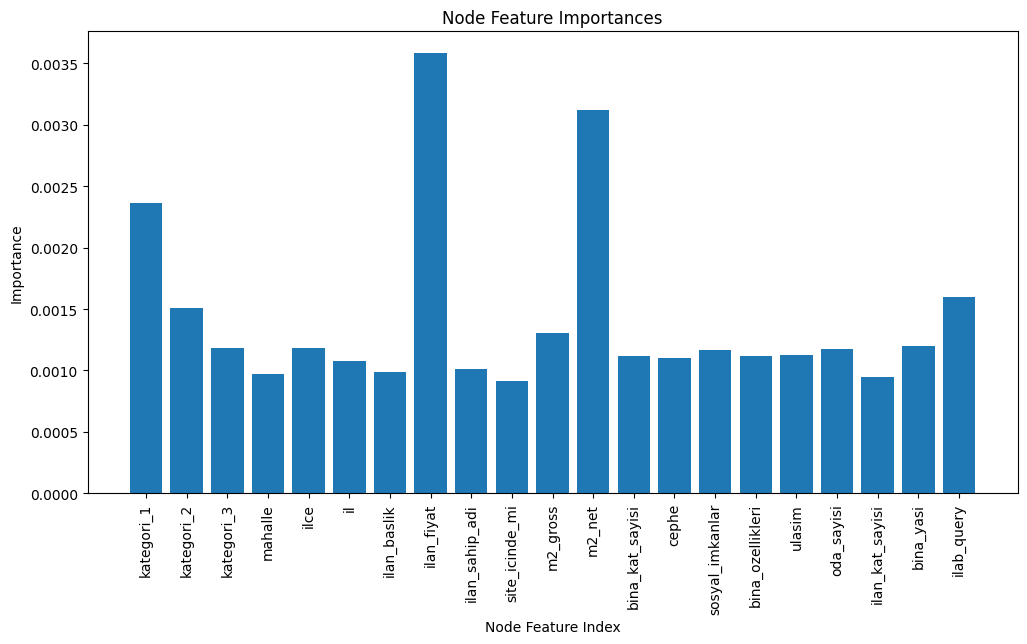

In [21]:
node_feature_importances /= kf.get_n_splits()
node_feature_names = [
    "kategori_1",
    "kategori_2",
    "kategori_3",
    "mahalle",
    "ilce",
    "il",
    "ilan_baslik",
    "ilan_fiyat",
    "ilan_sahip_adi",
    "site_icinde_mi",
    "m2_gross",
    "m2_net",
    "bina_kat_sayisi",
    "cephe",
    "sosyal_imkanlar",
    "bina_ozellikleri",
    "ulasim",
    "oda_sayisi",
    "ilan_kat_sayisi",
    "bina_yasi",
    "ilab_query",
]

plt.figure(figsize=(12, 6))
plt.bar(range(len(node_feature_importances)), node_feature_importances)
plt.xlabel("Node Feature Index")
plt.ylabel("Importance")
plt.title("Node Feature Importances")
plt.xticks(range(len(node_feature_names)), node_feature_names, rotation=90)
plt.show()

In [22]:
graph_data.x.shape

torch.Size([27656, 21])